# 配置环境

在运行之前需要安装所需的python包。建议使用anaconda创建一个新的虚拟环境，具体方法为打开Anaconda navigator，创建环境，环境名称可以命名为ByteBites。

激活环境，确保在vscode的资源管理器中打开ByteBites文件夹。在vscode的左侧python扩展中，在global environments，选中刚才安装的环境，点击open in terminal，在打开的命令行中输入以下命令安装所需的包：
```bash
pip install -r italy/requirements.txt
```

In [5]:
import pandas as pd
from langchain.prompts import (
    PromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    ChatPromptTemplate,)
from langchain_core.output_parsers import StrOutputParser
from langchain_community.vectorstores import FAISS
from langchain.schema.runnable import RunnablePassthrough
from langchain_community.document_loaders.dataframe import DataFrameLoader
from langchain.storage import LocalFileStore
from langchain.embeddings import CacheBackedEmbeddings
from langchain_openai import OpenAIEmbeddings, ChatOpenAI

DATASET_PATH = r"D:\000ai产品\ByteBites\Restaurant_5.23\restaurant_all.csv"

d:\Anaconda000\envs\ByteBites_ItalyRag\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


# 导入CSV数据库

以下代码从CSV文件导入餐厅数据，并生成一个新的文档对象documents。这个功能由DataFrameLoader提供。

### 数据结构说明

documents可以理解为一个list表格，每一行是包含两个字段的dict，两个字段分别为：  
- `page_content`：值为字符串。将餐厅的所有信息整合在一个字符串中，用于喂给大模型。
- `metadata`：值为dict。储存准备用于初过滤的硬性指标值，如经纬度、营业时间等。 

### 示例

假设原始csv文件如下：
```csv
name,address,location,type,tel,cost,rating,opentime_today,opentime_week,tag
巴蜀鱼花(南大店),湖南路街道汉口路30号,"118.779220,32.053685",餐饮服务;中餐厅;火锅店,15380870767,,4.4,09:00-21:00,周一至周日 09:00-21:00,
陕老顺肉夹馍,汉口路30号,"118.779105,32.053716",餐饮服务;餐饮相关场所;餐饮相关,15924140124,,4.4,10:00-21:00,周一至周日 10:00-21:00,肉夹馍
```

导入后的结果为：
```python
documents = [
    ..., # 第一行略
    {
        "page_content": "name=陕老顺肉夹馍\naddress=汉口路30号\nlocation=118.779105,32.053716\ntype=餐饮服务;餐饮相关场所;餐饮相关\ntag=肉夹馍\nrating=4.4\nopentime_today=10:00-21:00\nopentime_week=周一至周日 10:00-21:00\ntel=15924140124",
        "metadata": {
            "location": "118.779105,32.053716",
            "opentime_week": "周一至周日 10:00-21:00"
        }
    }
]
```

### **注意**

- 读取店铺数据的代码更改，导致csv文件中字段发生变化时：def content_func 中 python content_fields 的值要随之更改。
- 想作为硬性指标的字段发生变化时：调用部分 metadata_fields 中的值要更改。

In [6]:
def get_documents(content_func=lambda row: row['name'] + '\n' + row['tag'],
                  metadata_fields=[]):
    """
    加载并处理餐厅数据，生成文档对象
    
    参数:
        content_func: 处理page_content的函数
        metadata_fields: 需要包含在metadata中的字段列表
        
    返回:
        文档对象列表，包含page_content和metadata
    """
    # 加载数据库
    dataset_df = pd.read_csv(DATASET_PATH)
    dataset_df.drop_duplicates(inplace=True)
    
    # 处理内容
    dataset_df['page_content'] = dataset_df.apply(content_func, axis=1)
    
    # 确保page_content在metadata中
    metadata_fields = list(set(metadata_fields + ['page_content']))
    
    # 使用DataFrameLoader生成文档对象
    loader = DataFrameLoader(dataset_df[metadata_fields], page_content_column='page_content')
    return loader.load()

def content_func(row) -> str:
    """
    生成每家店铺的完整信息字符串
    
    参数:
        row: 数据行
        
    返回:
        包含店铺所有信息的字符串
    """
    # 基础信息字段
    content_fields = [
        "name", "address", "type", "tag", 
        "cost", "rating", "opentime_today", "opentime_week"
    ]
    
    # 新增的多维评价字段
    rating_fields = [
        "dp_rating", "dp_taste_rating", "dp_env_rating",
        "dp_service_rating", "dp_comment_num"
    ]
    
    # 推荐菜和评论相关字段
    comment_fields = [
        "dp_recommendation_dish", "dp_comment_keywords",
        "dp_top3_comments"
    ]
    
    # 生成信息字符串
    info_parts = []
    
    # 添加基础信息
    for field in content_fields:
        if pd.notna(row[field]):
            info_parts.append(f"{field}={row[field]}")
    
    # 添加评分信息
    rating_info = []
    for field in rating_fields:
        if pd.notna(row[field]):
            rating_info.append(f"{field}={row[field]}")
    if rating_info:
        info_parts.append("评分信息:\n" + "\n".join(rating_info))
    
    # 添加推荐菜和评论
    if pd.notna(row.get("dp_recommendation_dish")):
        info_parts.append(f"推荐菜: {row['dp_recommendation_dish']}")
    
    if pd.notna(row.get("dp_comment_keywords")):
        info_parts.append(f"评论关键词: {row['dp_comment_keywords']}")
    
    if pd.notna(row.get("dp_top3_comments")):
        info_parts.append("精选评论:\n" + row['dp_top3_comments'].replace("|", "\n"))
    
    return '\n'.join(info_parts)

# 调用 - 增加新字段到metadata中
metadata_fields = [
    "location", "opentime_week",
    "dp_rating", "dp_taste_rating", "dp_env_rating",
    "dp_service_rating", "dp_comment_num"
]

documents = get_documents(content_func, metadata_fields=metadata_fields)

# 展示更新后的文档结构
print("=== 更新后的文档示例 ===")
print(documents[1].page_content)
print("\n=== 元数据 ===")
print(documents[1].metadata)

=== 更新后的文档示例 ===
name=陕老顺肉夹馍
address=汉口路30号
type=餐饮服务;餐饮相关场所;餐饮相关
tag=肉夹馍
rating=4.4
opentime_today=10:00-21:00
opentime_week=周一至周日 10:00-21:00
评分信息:
dp_rating=3.4
dp_taste_rating=3.4
dp_env_rating=3.6
dp_service_rating=3.5
dp_comment_num=54.0
推荐菜: 招牌油泼面,岐山臊子面,纯瘦肉夹馍,麻酱凉皮,biangbiang 面,番茄鸡蛋面,牛肉牛筋面,鸡腿,酸辣砂锅米线,青椒肉夹馍
评论关键词: {"味道赞: 12", "口感赞: 4", "空间大: 3", "服务热情: 3", "干净整洁: 3", "肉夹馍: 20", "午餐: 7", "工作餐: 3", "分量少: 4"}
精选评论:
[("2025-04-21", "面香不够，辣油也不辣不香，整体没有油泼的质感，牛肉倒挺香，收银员不够热情，一直挂着脸，作为一个面馆，桌上不放纸巾不太好，还有就是加面条竟然还额外收费，这点不太友好，环境还行，收拾很干净 推荐：招牌油泼面"), ("2025-04-03", "出乎意料的精致！看起来就很有食欲，并且用料很丰富，口感不错好评！很好吃，口感很细腻，和图片上描述一致，非常好，我很喜欢 简直是宝藏，太好吃了，给的量也太足了！一周两次都吃不过。特别是凉皮，吃着很好吃"), ("2025-02-10", "因为就在学校旁边，经常过去吃，我比较喜欢吃他们家的凉皮 + 肉夹馍的组合，她家肉夹馍不腻，很香，凉皮很爽口。同学比较喜欢吃他们家的砂锅，味道也很不错，还有西红柿鸡蛋面也是我们比较常吃的，这家店还是比较推荐的。 推荐：纯瘦肉夹馍 酸辣砂锅米线 麻酱凉皮 番茄鸡蛋面 青椒肉夹馍")]

=== 元数据 ===
{'dp_comment_num': 54.0, 'opentime_week': '周一至周日 10:00-21:00', 'dp_rating': 3.4, 'dp_taste_rating': 3.4, 'dp_env_rating': 3.6, 'location': '118.779105,32.053716', 'dp_se

In [4]:
# from dotenv import load_dotenv
# from langchain_openai import OpenAIEmbeddings
# import os

# #加载环境变量
# load_dotenv()
# #配置嵌入模型
# EMBEDDING_MODEL_NAME = "text-embedding-3-small"  
# embedding_model = OpenAIEmbeddings(
#     model=EMBEDDING_MODEL_NAME,
#     openai_api_key=os.getenv("OPENAI_API_KEY")
# )

# 配置嵌入vecterbase所用的模型

用的是huggingface上面的某个轻量级开源模型。

In [7]:
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
import os
import numpy as np

# 初始化 HuggingFaceEmbeddings 模型，调整以支持多轮对话
embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True, "batch_size": 16}  # 增加批量处理支持
)

# 示例：生成多轮对话的嵌入向量
dialogue_history = [
    "用户：有没有四川的面馆？",
    "助手：有一家叫西安特色面馆的店，虽然是陕西菜，但也有类似的面食。",
    "用户：还有其他推荐吗？"
]

# 将对话历史拼接为单个字符串
dialogue_context = "\n".join(dialogue_history)
result = embedding_model.embed_query(dialogue_context)

# 转换为 numpy 数组并打印信息
array = np.array(result)
print(f"embedding shape: {array.shape}\nembedding norm: {np.linalg.norm(array, ord=2)}")

C:\Users\Admin\AppData\Local\Temp\ipykernel_26872\866045609.py:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(
d:\Anaconda000\envs\ByteBites_ItalyRag\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


embedding shape: (384,)
embedding norm: 0.9999999868027013


# FAISS数据库

在代码 FAISS_REVIEWS_PATH_COSINE = "faiss_index_cosine" 中，"faiss_index_cosine" 是 FAISS 向量索引的本地存储路径，保存的是经过向量化处理后的文档索引数据。以下是详细解释：

存储的具体内容
当调用 vector_db.save_local(FAISS_REVIEWS_PATH_COSINE) 时，会在该路径下生成以下文件：

index.faiss
二进制文件，存储向量索引的核心数据（包括向量数据、索引结构等）。

index.pkl（可选）
存储元数据（如文档的原始文本、ID等，需通过 LangChain 额外配置）。

这些文件共同构成一个完整的可复用的向量数据库。

In [8]:
FAISS_REVIEWS_PATH_COSINE = "faiss_index_cosine" # 向量库存储路径
FAISS_INDEX_NAME = "index" # 向量库索引名称
FAISS_DISTANCE_STRATEGY_COSINE = "COSINE_DISTANCE" # 向量库距离计算策略

# 用于根据csv数据生成向量库的函数。documents就是前面csv数据的导入结果。embedding_model就是上面定义的嵌入模型。
def get_vector_database(documents, embedding_model, distance_strategy):

  vector_database = FAISS.from_documents(
      documents, embedding_model,
      distance_strategy= distance_strategy
      )
  return vector_database

# 嵌入向量库。分批次处理文档，加入了等待时间，避免API限制（现在的版本是把向量库保存在本地，没有对应限制）。
import time
doclen = len(documents) # 这里的长度指的是前面读的数据的行数。
for batch in range(doclen//100 + 1): # 将每个店铺的信息独立转换为一个向量，且每次并行处理 100 个店铺的向量
    docs = documents[batch*100:(batch+1)*100]
    if batch == 0:
        vector_db = get_vector_database(docs, embedding_model, FAISS_DISTANCE_STRATEGY_COSINE)
    else:
        vector_db.merge_from(get_vector_database(docs, embedding_model, FAISS_DISTANCE_STRATEGY_COSINE))
    time.sleep(10) # 每次处理完100条数据，休眠10秒，防止api限制。
    
#储存并加载向量库
vector_db.save_local(folder_path=FAISS_REVIEWS_PATH_COSINE, index_name=FAISS_INDEX_NAME)
vector_db = FAISS.load_local(folder_path=FAISS_REVIEWS_PATH_COSINE,
                             embeddings=embedding_model,
                             index_name=FAISS_INDEX_NAME,
                             allow_dangerous_deserialization=True) # 允许反序列化

### 验证效果

In [11]:
docs = vector_db.similarity_search("陕西肉夹馍", k = 5)
for doc in docs:
    print(doc, end="\n\n")

page_content='name=可西玛西班牙餐厅
address=上海路120号(上海路南京银行对面与汉口交叉路口)
type=餐饮服务;外国餐厅;地中海风格菜品
tag=西班牙海鲜饭,土豆饼,桑格利亚,披萨,芝士火腿烤土豆,tapas,墨鱼海鲜饭,蒜香烤翅,凯撒沙拉,可西马披萨,可西玛沙拉,巴塞罗那小吃,金枪鱼色拉,马德里小吃,西班牙女士啤酒（柠檬味）,海鲜饭,大虾,pizza
cost=81.0
rating=4.5
opentime_today=10:00-21:30
opentime_week=周一至周日 10:00-21:30
评分信息:
dp_rating=4.4
dp_taste_rating=4.4
dp_env_rating=4.2
dp_service_rating=4.4
dp_comment_num=1744.0
推荐菜: 西班牙海鲜饭,Tapas拼盘,士豆饼,桑格利亚,烤猪肋排,牛肉奶酪TAPAS,墨鱼汁海鲜面,地中海烤翅,墨鱼汁面,可西玛披萨
评论关键词: {"上菜快": 33, "不用排队": 8, "闺蜜聚会": 28, "约会圣地": 26, "朋友聚餐": 24, "文艺清新": 21, "现做现卖": 21, "下午茶": 10, "弄堂小店": 10, "店内消毒": 1}
精选评论:
[("2025-05-27", "由于店面超级迷你，导致这么多年竟然没有发现过这家店。\n 由于间歇性想吃西班牙海鲜饭找过来的，口味还可以但没有惊艳。\n 相对来说金枪鱼沙拉更好吃，品质不错。"), ("2025-05-24", "很久以前吃的了。确实挺好的。特别好吃的海鲜饭忘记拍了。"), ("2025-05-24", "环境着实有点小，店里只能坐 3 - 4 桌这样，不过室外也有座位，也可以坐！\n「西班牙海鲜饭」算是招牌必点的海鲜饭，虾还不错，青口贝有点腥，米饭偏软的口感，吃多了会稍微有点腻 \n「Tapas 拼盘」推荐其中一个牛肉的，还不错！拼盘就是每个味道都可以尝到啦！")]' metadata={'dp_comment_num': 1744.0, 'opentime_week': '周一至周日 10:00-21:30', 'dp_rating': 4.4, 'dp_taste_rating': 4.4, 'dp_env_rat

In [12]:
docs = vector_db.similarity_search("披萨", k = 5)
for doc in docs:
    print(doc, end="\n\n")

page_content='name=台式烩饭(金银街小区店)
address=上海路158号1栋2单元
type=餐饮服务;中餐厅;台湾菜
cost=17.0
rating=4.4
opentime_today=09:00-22:00
opentime_week=周一至周日 09:00-22:00' metadata={'dp_comment_num': nan, 'opentime_week': '周一至周日 09:00-22:00', 'dp_rating': nan, 'dp_taste_rating': nan, 'dp_env_rating': nan, 'location': '118.774736,32.057582', 'dp_service_rating': nan}

page_content='name=鱼你在一起(恒基中心公寓店)
address=丹凤街29号大润发一层
type=餐饮服务;餐饮相关场所;餐饮相关
rating=4.2
opentime_today=09:00-21:00
opentime_week=周一至周日 09:00-21:00' metadata={'dp_comment_num': nan, 'opentime_week': '周一至周日 09:00-21:00', 'dp_rating': nan, 'dp_taste_rating': nan, 'dp_env_rating': nan, 'location': '118.786668,32.054497', 'dp_service_rating': nan}

page_content='name=元满烧鸟居酒屋
address=唱经楼西街3-7号唱经楼小区
type=餐饮服务;外国餐厅;日本料理
tag=居酒屋,烧鸟
rating=4.2' metadata={'dp_comment_num': nan, 'opentime_week': nan, 'dp_rating': nan, 'dp_taste_rating': nan, 'dp_env_rating': nan, 'location': '118.786605,32.053287', 'dp_service_rating': nan}

page_content='name=三顾冒菜(珠江路店)


# 配置大语言模型
需要在ByteBites目录下创建配置文件.env，里面添加大语言模型的配置信息。密钥要自己申请。代码支持的模型包括：OpenAI、Deepseek、通义千问等。

.env文件形如：

```python
# OpenAI
OPENAI_API_KEY = 
OPENAI_MODEL_NAME = "gpt-4o-mini"

# Deepseek
DEEPSEEK_API_KEY = 
DEEPSEEK_BASE_URL = 'https://api.deepseek.com'
DEEPSEEK_MODEL_V3 = 'deepseek-chat'
DEEPSEEK_MODEL_R1 = 'deepseek-reasoner'
```

In [13]:
import os
from dotenv import load_dotenv
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage
import getpass

# 载入本地 .env 文件
load_dotenv()

# 设置 DeepSeek API KEY
if not os.environ.get("DEEPSEEK_API_KEY"):
    os.environ["DEEPSEEK_API_KEY"] = getpass.getpass("Enter API key for DeepSeek-AI: ")

# 初始化 LangChain 的 ChatOpenAI（适配 DeepSeek）
llm = ChatOpenAI(
    openai_api_key=os.environ["DEEPSEEK_API_KEY"],
    openai_api_base="https://api.deepseek.com/v1",
    model_name="deepseek-reasoner",  # 或者 deepseek-v3，具体根据官方命名
    temperature=0.7
)

# 示例对话调用
response = llm([HumanMessage(content="你好，请用一句话介绍你自己")])
print(response.content)

C:\Users\Admin\AppData\Local\Temp\ipykernel_26872\3020143093.py:15: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(
C:\Users\Admin\AppData\Local\Temp\ipykernel_26872\3020143093.py:23: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm([HumanMessage(content="你好，请用一句话介绍你自己")])


我是由中国的深度求索（DeepSeek）公司开发的智能助手DeepSeek-R1，擅长通过思考来帮助您解答复杂数学、代码和逻辑推理等难题，并提供专业友好的建议。


In [10]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
messages = [
    SystemMessage("Translate the following from English into French"),
    HumanMessage("hi!"),
]
llm.invoke(messages)

AIMessage(content='Salut !', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 175, 'prompt_tokens': 15, 'total_tokens': 190, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 170, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 15}, 'model_name': 'deepseek-reasoner', 'system_fingerprint': 'fp_5417b77867_prod0425fp8', 'finish_reason': 'stop', 'logprobs': None}, id='run-71c17fbd-183b-4a30-bb32-890b2cf4044d-0')

# 用LangChain包设置和大模型交互的工作流

In [14]:
from langchain.prompts import (
    PromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    ChatPromptTemplate,
)
from langchain_core.output_parsers import StrOutputParser
from langchain_community.vectorstores import FAISS
from langchain.schema.runnable import RunnablePassthrough, RunnableMap
from langchain.memory import ConversationBufferMemory

# 初始化对话历史记忆模块
memory = ConversationBufferMemory(memory_key="history", return_messages=True)

# 修改系统提示模板以包含对话历史
system_prompt_template = """
# 你的角色

你是一个餐厅推荐助手。你的工作是使用数据库中的餐馆详细信息来为用户推荐最佳就餐地点。

# 规则

你只能根据数据库中的信息回答用户问题。
如果你发现数据库中有与主题无关的信息，请忽略。
如果你发现用户问题与就餐无关，请告诉用户你只能回答与餐厅相关的问题。
如果你看了数据库后还是不知道答案，就说你不知道。

# 数据库的格式

每家餐馆的信息包括：
name餐馆名字
address地址
type餐馆类型
tag餐馆标签
rating用户评分（越高越好）
opentime_today每天营业时间
opentime_week星期几营业
dp_rating大众点评评分
dp_taste_rating大众点评口味评分
dp_env_rating大众点评环境评分
dp_service_rating大众点评服务评分
dp_comment_num大众点评评论数量
dp_recommendation_dish大众点评推荐菜
dp_comment_keywords大众点评评论关键词
dp_top3_comments大众点评精选评论
请注意，以上信息可能会有缺失或不完整的情况。
# 对话历史

{history}

# 数据库内容

{context}
"""

human_prompt_template = """
{question}
"""

# 使用langchain自带的prompts模板编辑器来编辑prompt格式
system_prompt = SystemMessagePromptTemplate(
    prompt=PromptTemplate(
        input_variables=["history", "context"], template=system_prompt_template
    )
)
human_prompt = HumanMessagePromptTemplate(
    prompt=PromptTemplate(input_variables=["question"], template=human_prompt_template)
)
messages = [system_prompt, human_prompt]
total_prompt_template = ChatPromptTemplate(
    input_variables=["history", "context", "question"], messages=messages
)

# 配置RAG的初步检索器
reviews_retriever = vector_db.as_retriever(search_kwargs={'k': 20,})

# 配置和大模型交互的完整chatbot，加入历史记忆
review_chain = (
    RunnableMap({
        "history": RunnablePassthrough(lambda _: memory.load_memory_variables({})),  # 修复 lambda 函数
        "context": reviews_retriever,
        "question": RunnablePassthrough()
    })
    | total_prompt_template
    | llm
    | StrOutputParser()
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_26872\428841683.py:13: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="history", return_messages=True)


### 使用示例

In [15]:
question = """有没有四川的面馆"""
response = review_chain.invoke(question)

# 更新对话历史
memory.save_context({"input": question}, {"output": response})

print(response)

根据数据库中的信息，以下是为您推荐的四川面馆：

1. **四川宜宾燃面**  
📍地址：汉口路48号  
🌟评分：4.7（用户评分） | 大众点评评分：4.1  
🍜推荐菜：招牌燃面、肥肠米线、辣子鸡面、燃抄手  
⏰营业时间：周一至周日 09:00-20:30  
📝亮点：  
- 评论关键词显示“主食赞”“上菜快”“弄堂小店”  
- 精选评论提到“份量很大”“性价比超级高”，人均约30元  
- 推荐尝试白肉和萝卜小菜等川味小吃  

2. **重庆鸡公煲（广州路店）**（备选，含火锅面）  
📍地址：海苑大厦北2门旁  
🌟评分：4.2（用户评分） | 大众点评评分：3.9  
🍜推荐菜：鸡公煲配火锅面  
⏰营业时间：数据库未明确标注，建议提前确认  
📝亮点：  
- 鸡肉肉质细嫩，可加配菜涮煮  
- 精选评论提到油条吸汤汁很入味  

其他川味餐厅如「赵椒椒川味麻辣烫」显示“推荐菜: 停业”，暂不推荐。  
若有更多需求（如环境、辣度等），可进一步筛选！


In [16]:
question = """根据上面的信息，推荐一家好吃的面馆"""
response = review_chain.invoke(question)

# 更新对话历史
memory.save_context({"input": question}, {"output": response})

print(response)

根据数据库中的信息，我推荐 **兰州拉面刀削面(汉口路店)**，以下是推荐理由：

1. **高用户评分**：综合评分4.5（数据库中最高之一），大众点评口味/环境/服务评分均衡（3.8-3.9）。
2. **特色菜品**：主打干切牛肉刀削面（评论称“劲道十足，配菜丰富”）、烤羊肉串、牛肉炒拉面等，推荐菜多达10种。
3. **口碑亮点**：
   - 评论关键词提到“味道赞”（25次）、“服务热情”（17次）、“性价比高”（11次）。
   - 精选评论强调“牛肉刀削面鲜美”“环境干净”“老板热情”。
4. **营业便利**：每日09:00-21:00全周营业，汉口路36号交通便利。

若偏好其他风味，可备选：
- **西安特色面食(广州路)**：岐山臊子面、油泼面口碑好，但评分略低（4.1）。
- **蟹员外蟹黄面**：评分4.8最高，主打蟹黄面，但人均52元较高。

请根据口味偏好选择~


In [14]:
question = """上面所有的信息中，哪一家是在上海路"""
response = review_chain.invoke(question)

# 更新对话历史
memory.save_context({"input": question}, {"output": response})

print(response)

根据数据库中的信息，以下餐馆位于上海路：

1. **阿爸饭桌(上海路店)**  
   - 地址：上海路209号南楼102  
   - 类型：韩国料理  
   - 评分：4.6  
   - 营业时间：周一至周日 11:00-13:30，17:00-20:30  

2. **泰姬玛哈印度料理(上海路店)**  
   - 地址：上海路187-1号（云南路地铁站2号口步行390米）  
   - 类型：印度风味  
   - 评分：4.2  
   - 营业时间：周一至周日 10:30-22:30  

3. **靖小馆·大馄饨(上海路店)**  
   - 地址：上海路209号1幢101室  
   - 类型：中餐厅  
   - 评分：4.4  
   - 营业时间：周一至周日 10:00-21:00  

4. **玄姬Bistro**  
   - 地址：上海路85号上海路小区  
   - 类型：西餐厅（综合风味）  
   - 评分：4.4  
   - 营业时间：周一至周日 11:30-21:30  

5. **紫燕百味鸡(上海路店)**  
   - 地址：汉口西路22号上海路农贸市场内  
   - 类型：中餐厅  
   - 评分：4.5  
   - 营业时间：周一至周日 08:00-18:30  

6. **台式烩饭(金银街小区店)**  
   - 地址：上海路158号1栋2单元  
   - 类型：台湾菜  
   - 评分：4.4  
   - 营业时间：周一至周日 09:00-22:00  

7. **老马牛肉面(上海路店)**  
   - 地址：上海路154号4幢106室  
   - 类型：清真菜馆  
   - 评分：4.5  
   - 营业时间：周一至周日 09:00-23:00  

以上餐厅均在上海路或地址中明确包含“上海路”。


In [17]:
# 示例：经典演示历史对话功能
# 第一次提问：询问是否有四川的面馆
question1 = "有没有四川的面馆"
response1 = review_chain.invoke(question1)
memory.save_context({"input": question1}, {"output": response1})
print(f"用户提问: {question1}\n助手回答: {response1}\n")

# 第二次提问：基于历史对话，进一步询问推荐
question2 = "推荐一家评分最高的四川面馆"
response2 = review_chain.invoke(question2)
memory.save_context({"input": question2}, {"output": response2})
print(f"用户提问: {question2}\n助手回答: {response2}\n")

# 第三次提问：基于历史对话，询问营业时间
question3 = "这家面馆今天几点开门？"
response3 = review_chain.invoke(question3)
memory.save_context({"input": question3}, {"output": response3})
print(f"用户提问: {question3}\n助手回答: {response3}\n")

用户提问: 有没有四川的面馆
助手回答: 根据数据库中的信息，找到以下符合要求的四川面馆：

1. **四川宜宾燃面**
   - 地址：汉口路48号
   - 类型：四川菜（川菜）
   - 评分：4.7（用户评分）｜4.1（大众点评）
   - 推荐菜：招牌燃面、肥肠米线、辣子鸡面、燃抄手
   - 特色亮点：
     - 评论关键词高频出现"主食赞"（83次）、"弄堂小店"（114次）
     - 精选评论提到"份量很大"、"性价比超级高"、"人均30元"
     - 营业时间：周一至周日 09:00-20:30

该店是典型四川面馆，主打燃面及川味米线，2800条大众点评评论验证其口碑，适合追求地道川味和性价比的食客。其他四川菜餐厅虽有面食但非主营品类，故未作推荐。

用户提问: 推荐一家评分最高的四川面馆
助手回答: 根据数据库中的信息，评分最高的四川面馆是 **四川宜宾燃面**，以下是详细信息：

- **地址**：汉口路48号  
- **评分**：用户评分4.7（大众点评评分4.1）  
- **营业时间**：周一至周日 09:00-20:30  
- **推荐菜**：招牌燃面、白肉、萝卜小菜、蹄花汤、豆花  
- **评论关键词**：弄堂小店（114次提及）、主食赞（83次提及）、上菜快（31次提及）  
- **精选评论**：  
  - "味道很不错，店里空调挺足的，份量很大推荐：招牌燃面"  
  - "老店了，招牌燃面和小吃很丰富"  

该店提供地道的四川面食，且评分和口碑均领先于其他同类餐厅。

用户提问: 这家面馆今天几点开门？
助手回答: 根据数据库中的信息，以下是几家面馆今天的营业时间：

1. **梁记皮肚面**  
   今天营业时间：17:00 - 次日00:30  
   *地址：吉兆花园1号107室*

2. **穆兰说兰州牛肉面**  
   今天营业时间：09:00 - 21:00  
   *地址：广州路39号（儿童医院对面）*

3. **老街大肉面**  
   今天营业时间：07:00 - 19:30  
   *地址：南阴阳营1号103室*

如果需要其他帮助，请进一步说明！



## 新增功能：地图打卡日记

In [17]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from langchain.agents import AgentExecutor, Tool
from langchain_core.messages import AIMessage, HumanMessage
import json
import os
from datetime import datetime

# 文件路径
DATA_PATH = r"D:\000ai产品\ByteBites\Restaurant_5.23\Amap-results_NJU-Gulou-3000m.csv"
CHECKIN_PATH = r"D:\000ai产品\ByteBites\Restaurant_5.23\地图打卡.csv"

# 初始化打卡文件（如果不存在）
if not os.path.exists(CHECKIN_PATH):
    pd.DataFrame(columns=['date', 'name', 'diary']).to_csv(CHECKIN_PATH, index=False)

# 修改读取打卡文件的逻辑，允许空文件
def read_checkin_file():
    """读取打卡文件，允许空文件"""
    try:
        checkin_df = pd.read_csv(CHECKIN_PATH)
        if checkin_df.empty:
            return pd.DataFrame(columns=['date', 'name', 'diary'])
        return checkin_df
    except pd.errors.EmptyDataError:
        return pd.DataFrame(columns=['date', 'name', 'diary'])

# 1. 地理空间可视化基础功能
def plot_restaurants():
    """绘制所有餐厅的地理分布图"""
    # 读取数据
    df = pd.read_csv(DATA_PATH)
    
    # 创建GeoDataFrame
    geometry = [Point(float(xy.split(',')[0]), float(xy.split(',')[1])) 
                for xy in df['location']]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    
    # 转换为中国常用坐标系
    gdf = gdf.to_crs("EPSG:4490")
    
    # 绘制基础地图
    fig, ax = plt.subplots(figsize=(12, 10))
    gdf.plot(ax=ax, color='blue', markersize=20, label='未打卡')
    
    # 美化图表
    ax.set_title('南京鼓楼区美食地图', fontsize=16)
    ax.set_xlabel('经度', fontsize=12)
    ax.set_ylabel('纬度', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return gdf, fig

# 2. 打卡功能工具
def process_checkin(input_text, llm):
    """处理用户打卡输入"""
    # 解析用户输入
    prompt = f"""
    请从以下用户输入中提取信息：
    1. 日期（格式如5.23或5月23日）
    2. 餐厅名称（必须与{DATA_PATH}中的name列完全一致）
    3. 日记内容（去除日期信息）
    
    用户输入：{input_text}
    
    请以JSON格式返回，包含date、name和diary三个字段。
    """
    
    # 使用LLM解析
    response = llm.invoke(prompt)
    try:
        # 处理LLM返回的非标准JSON响应
        if response.startswith('```json'):
            response = response[7:-3]  # 去除Markdown代码块标记
        data = json.loads(response)
    except Exception as e:
        print(f"解析失败: {e}")
        return "解析失败，请确保包含日期和餐厅名称"
    
    # 验证餐厅是否存在
    df = pd.read_csv(DATA_PATH)
    if data['name'] not in df['name'].values:
        return "您这次去的店不在基本数据库内"
    
    # 保存打卡记录
    checkin_df = read_checkin_file()  # 使用新的读取逻辑
    new_record = pd.DataFrame([{
        'date': data['date'],
        'name': data['name'],
        'diary': data['diary']
    }])
    checkin_df = pd.concat([checkin_df, new_record], ignore_index=True)
    checkin_df.to_csv(CHECKIN_PATH, index=False)
    
    # 更新可视化
    update_visualization()
    
    return "打卡成功！已记录您的用餐体验。"

def update_visualization():
    """更新可视化图表"""
    # 读取基础数据
    gdf, fig = plot_restaurants()
    
    # 读取打卡数据
    checkin_df = read_checkin_file()
    checked_in = gdf[gdf['name'].isin(checkin_df['name'])]
    not_checked = gdf[~gdf['name'].isin(checkin_df['name'])]
    
    # 重新绘制
    plt.close('all')
    fig, ax = plt.subplots(figsize=(12, 10))
    not_checked.plot(ax=ax, color='blue', markersize=20, label='未打卡')
    checked_in.plot(ax=ax, color='red', markersize=50, marker='*', label='已打卡')
    
    # 计算打卡百分比
    percent = round(len(checked_in)/len(gdf)*100, 1)
    ax.set_title(f'南京鼓楼区美食地图（已探索{percent}%）', fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def query_diary(date_query, llm):
    """查询特定日期的日记"""
    checkin_df = read_checkin_file()  # 使用新的读取逻辑
    day_records = checkin_df[checkin_df['date'] == date_query]
    
    if day_records.empty:
        return f"{date_query}没有找到打卡记录"
    
    # 使用LLM总结当天的日记
    prompt = f"""
    请总结以下用户在{date_query}的用餐体验：
    {day_records['diary'].str.cat(sep='\\n')}
    
    请用一段话概括用户当天的美食体验和心情。
    """
    
    summary = llm.invoke(prompt)
    locations = "、".join(day_records['name'].unique())
    
    return f"{date_query}打卡记录：\\n去了{locations}\\n总结：{summary}"

# 3. 创建工具并集成到主应用
def create_checkin_tools(llm):
    """创建打卡工具集"""
    tools = [
        Tool(
            name="process_checkin",
            func=lambda x: process_checkin(x, llm),
            description="处理用户的美食打卡日记，输入应为用户包含日期和餐厅名称的文本"
        ),
        Tool(
            name="query_diary",
            func=lambda x: query_diary(x, llm),
            description="查询特定日期的美食日记，输入应为日期字符串如'5.23'"
        ),
        Tool(
            name="update_visualization",
            func=lambda _: update_visualization(),
            description="更新美食地图可视化"
        )
    ]
    return tools

# 4. 主处理函数
def handle_user_input(user_input, llm):
    """处理用户输入路由"""
    # 初始化工具
    tools = create_checkin_tools(llm)
    
    # 判断输入类型
    if "今天我去吃了" in user_input or "打卡" in user_input:
        return tools[0].func(user_input)
    elif "我想看看" in user_input and "日我做了什么" in user_input:
        # 提取日期
        date_response = llm.invoke(f"从以下文本提取日期（格式如5.23或5月23日）：{user_input}")
        # 修复：从 AIMessage 对象中提取 content 属性
        date = date_response.content.strip().strip('"').strip("'")
        return tools[1].func(date)
    else:
        # 原有RAG功能
        return "这是原有RAG功能的响应占位符"

解析失败: 'AIMessage' object has no attribute 'startswith'
解析失败，请确保包含日期和餐厅名称
从文本中提取的日期为：5月23日

解析步骤：
1. 原句中的日期表达为“5.23日”，包含点号格式和汉字“日”的混合使用。
2. 根据中文日期规范，点号格式（如5.23）通常不带“日”字，而汉字格式（5月23日）需明确包含“月”和“日”。
3. 结合原句中的“日”字，判断用户实际意图为汉字格式，故将“5.23日”规范化为「5月23日」。

答案：5月23日没有找到打卡记录


C:\Users\Admin\AppData\Local\Temp\ipykernel_28652\2247481553.py:54: UserWarning: Glyph 32463 (\N{CJK UNIFIED IDEOGRAPH-7ECF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_28652\2247481553.py:54: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_28652\2247481553.py:54: UserWarning: Glyph 32428 (\N{CJK UNIFIED IDEOGRAPH-7EAC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_28652\2247481553.py:54: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_28652\2247481553.py:54: UserWarning: Glyph 20140 (\N{CJK UNIFIED IDEOGRAPH-4EAC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_28652\2247481553.py:54: UserWarning: Glyph 40723 (\

ValueError: aspect must be finite and positive 

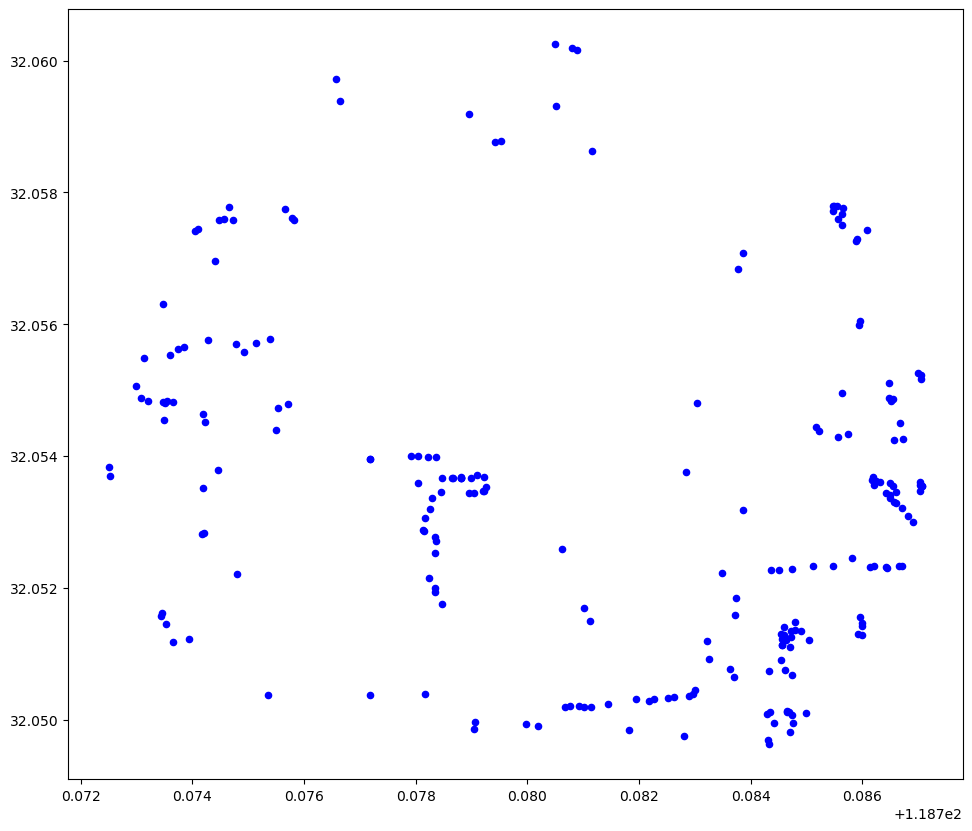

In [18]:
# 初始化LLM (使用项目中已有的LLM)
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
    openai_api_key=os.environ["DEEPSEEK_API_KEY"],
    openai_api_base="https://api.deepseek.com/v1",
    model_name="deepseek-reasoner",  
    temperature=0.7
)

# 示例1：打卡记录
user_input = "5.23日，今天我去吃了茶悦笼蟹黄汤包，好开心哎，吃到了美味的蟹黄汤包，天气非常不错，代码也跑了出来，总之今天非常开心"
response = handle_user_input(user_input, llm)
print(response)

# 示例2：查询日记
user_input = "我想看看5.23日我做了什么"
response = handle_user_input(user_input, llm)
print(response)

# 查看可视化效果
update_visualization()

In [31]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os

def plot_poi_map(amap_csv, checkin_csv=None, save_path=None):
    # 加载POI点
    df_poi = pd.read_csv(amap_csv)

    # 拆分location为lng和lat列
    df_poi[['lng', 'lat']] = df_poi['location'].str.split(',', expand=True).astype(float)

    # 构建GeoDataFrame
    gdf_poi = gpd.GeoDataFrame(df_poi,
                               geometry=gpd.points_from_xy(df_poi.lng, df_poi.lat),
                               crs="EPSG:4326")

    # 转换坐标系（中国近似地理坐标系）
    gdf_poi = gdf_poi.to_crs(epsg=4490)

    # 加载打卡数据（可选）
    checked_names = set()
    if checkin_csv and os.path.exists(checkin_csv):
        try:
            df_checkin = pd.read_csv(checkin_csv)
            if 'name' in df_checkin.columns:
                checked_names = set(df_checkin['name'].dropna().unique())
            else:
                print("警告：打卡文件存在但缺少 'name' 列，将忽略打卡记录。")
        except Exception as e:
            print(f"读取打卡文件失败：{e}")
    elif checkin_csv:
        # 若文件不存在则创建空文件（带列名）
        pd.DataFrame(columns=["date", "name", "diary"]).to_csv(checkin_csv, index=False)
        print(f"打卡文件未找到，已自动创建空文件：{checkin_csv}")

    # 标记是否打卡
    gdf_poi['checked'] = gdf_poi['name'].apply(lambda x: x in checked_names)

    # 🎨 绘图
    fig, ax = plt.subplots(figsize=(10, 8))

    # 绘制未打卡点
    gdf_poi[~gdf_poi['checked']].plot(ax=ax, color='lightgray', markersize=10, label="未打卡")

    # 安全绘制已打卡点（防止空）
    if gdf_poi['checked'].any():
        gdf_poi[gdf_poi['checked']].plot(ax=ax, color='red', markersize=30, label="已打卡")

    ax.set_title("南大鼓楼美食地图", fontsize=16)
    ax.legend()
    plt.axis('off')


    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # 输出探索百分比
    explored = gdf_poi['checked'].sum()
    total = len(gdf_poi)
    percent = explored / total * 100
    print(f"南大附近您已经探索了 {percent:.2f}% 的店铺。")



读取打卡文件失败：No columns to parse from file


d:\Anaconda000\envs\ByteBites_ItalyRag\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda000\envs\ByteBites_ItalyRag\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda000\envs\ByteBites_ItalyRag\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 40723 (\N{CJK UNIFIED IDEOGRAPH-9F13}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda000\envs\ByteBites_ItalyRag\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27004 (\N{CJK UNIFIED IDEOGRAPH-697C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda000\envs\ByteBites_ItalyRag\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 

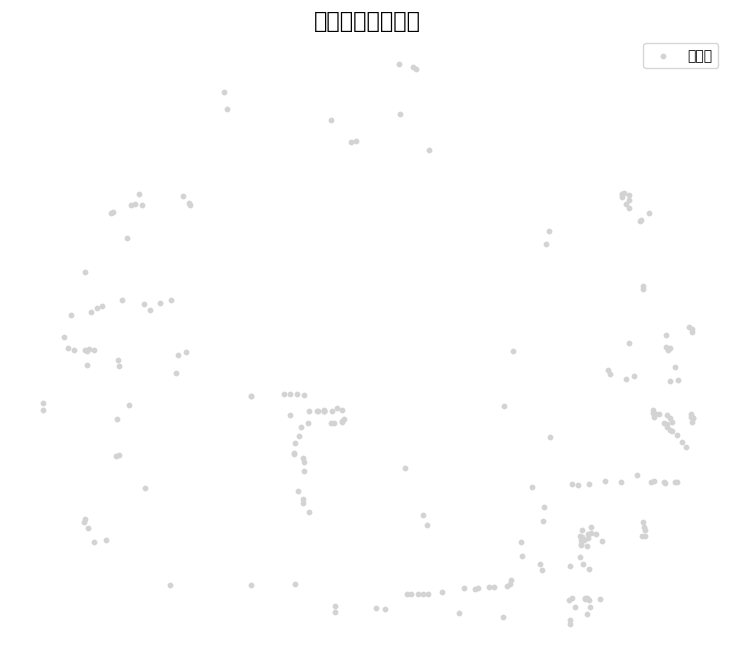

南大附近您已经探索了 0.00% 的店铺。


In [32]:
amap_path = r"D:\000ai产品\ByteBites\Restaurant_5.23\Amap-results_NJU-Gulou-3000m.csv"
diary_path = r"D:\000ai产品\ByteBites\Restaurant_5.23\地图打卡.csv"

plot_poi_map(amap_path, checkin_csv=diary_path)

In [34]:
import re
import pandas as pd
from datetime import datetime
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate

def parse_diary(text):
    # 简单解析日期和地点
    date_match = re.search(r"(\d{1,2}\.\d{1,2})日?", text)
    name_match = re.search(r"去吃了(.+?)[，。]", text)
    
    date = date_match.group(1) if date_match else None
    name = name_match.group(1).strip() if name_match else None

    diary = text
    if date:
        diary = diary.replace(date + "日", "")
    if name:
        diary = diary.replace("去吃了" + name, "")
    
    return date, name, diary.strip()

def check_and_save_diary(user_input, amap_path, diary_path):
    date, name, diary = parse_diary(user_input)
    if not date or not name:
        return "解析失败，请确认输入包含日期和地点。"

    amap_df = pd.read_csv(amap_path)
    if name not in amap_df['name'].values:
        return "您这次去的店不在基本数据库内，未记录。"

    # 保存
    today = datetime.now().strftime("%Y-%m-%d")
    record = pd.DataFrame([[f"2025.{date}", name, diary]], columns=["date", "name", "diary"])
    try:
        old = pd.read_csv(diary_path)
        new_df = pd.concat([old, record], ignore_index=True)
    except FileNotFoundError:
        new_df = record
    new_df.to_csv(diary_path, index=False)

    return f"已记录打卡日记：{name}（{date}）"


In [43]:
user_input = "5.23日，今天我去吃了福桔家庭厨房，好开心哎，吃到了美味的蟹黄汤包，天气非常不错，代码也跑了出来，总之今天非常开心"
amap_path = r"D:\000ai产品\ByteBites\Restaurant_5.23\Amap-results_NJU-Gulou-3000m.csv"
diary_path = r"D:\000ai产品\ByteBites\Restaurant_5.23\地图打卡.csv"
result = check_and_save_diary(user_input, amap_path, diary_path)
print(result)


EmptyDataError: No columns to parse from file

In [35]:
from langchain.chat_models import ChatOpenAI
import pandas as pd

def summarize_day_diary(date_query, diary_path):
    df = pd.read_csv(diary_path)
    results = df[df['date'] == date_query]
    
    if results.empty:
        return "这一天您似乎没有打卡记录哦～"

    combined_diary = " ".join(results['diary'].values)

    llm = ChatOpenAI(
    openai_api_key=os.environ["DEEPSEEK_API_KEY"],
    openai_api_base="https://api.deepseek.com/v1",
    model_name="deepseek-reasoner",  # 或者 deepseek-v3，具体根据官方命名
    temperature=0.7
)
    prompt = f"""
你是一位日记总结机器人，帮我总结这一天发生了什么。
以下是我的日记内容：

{combined_diary}

请用自然语言总结一下。
"""
    return llm.predict(prompt)


读取打卡文件失败：No columns to parse from file


d:\Anaconda000\envs\ByteBites_ItalyRag\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda000\envs\ByteBites_ItalyRag\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda000\envs\ByteBites_ItalyRag\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 40723 (\N{CJK UNIFIED IDEOGRAPH-9F13}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda000\envs\ByteBites_ItalyRag\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27004 (\N{CJK UNIFIED IDEOGRAPH-697C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda000\envs\ByteBites_ItalyRag\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 

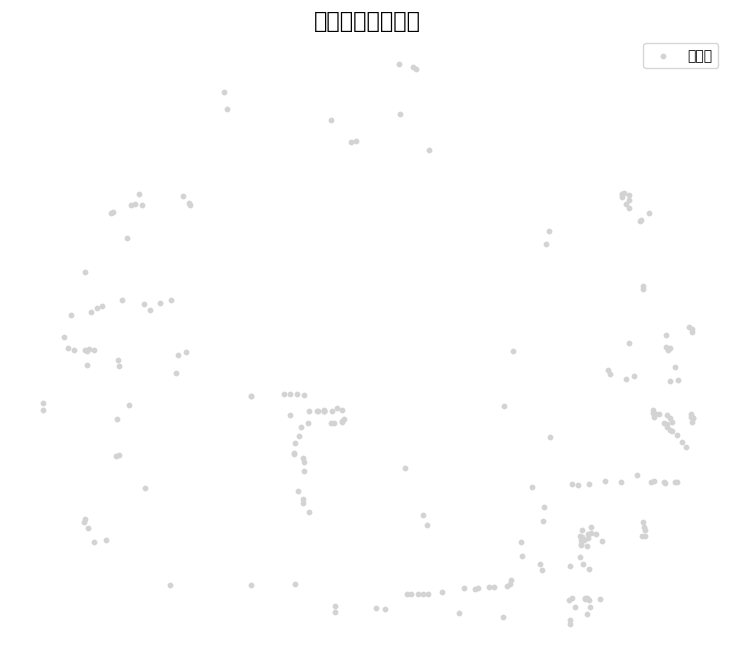

南大附近您已经探索了 0.00% 的店铺。
您这次去的店不在基本数据库内，未记录。
读取打卡文件失败：No columns to parse from file


d:\Anaconda000\envs\ByteBites_ItalyRag\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda000\envs\ByteBites_ItalyRag\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda000\envs\ByteBites_ItalyRag\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 40723 (\N{CJK UNIFIED IDEOGRAPH-9F13}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda000\envs\ByteBites_ItalyRag\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27004 (\N{CJK UNIFIED IDEOGRAPH-697C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda000\envs\ByteBites_ItalyRag\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 

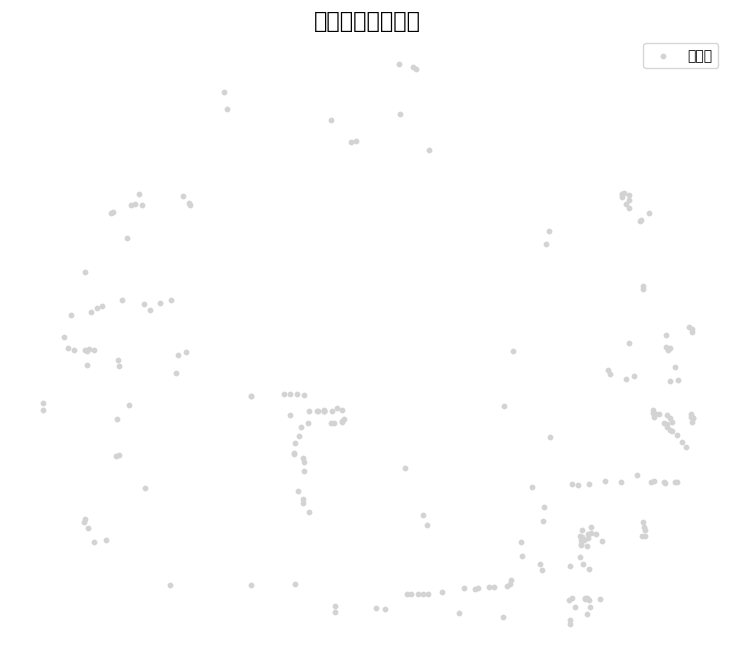

南大附近您已经探索了 0.00% 的店铺。


EmptyDataError: No columns to parse from file

In [36]:

amap_path = r"D:\000课题组\000课题实验\5.21RAG+餐饮\Amap-results_NJU-Gulou-3000m.csv"
diary_path = r"D:\000课题组\000课题实验\5.21RAG+餐饮\地图打卡.csv"

# Step 1: 地图初始绘制
plot_poi_map(amap_path, checkin_csv=diary_path)

# Step 2: 用户输入日记打卡
user_input = "5.23日，今天我去吃了茶悦笼蟹黄汤包，好开心哎，吃到了美味的蟹黄汤包，天气非常不错，代码也跑了出来，总之今天非常开心"
result = check_and_save_diary(user_input, amap_path, diary_path)
print(result)

# Step 3: 打卡后更新地图
plot_poi_map(amap_path, checkin_csv=diary_path)

# Step 4: 查看某天日记
summary = summarize_day_diary("2025.5.22", diary_path)
print(summary)


In [24]:
import pandas as pd

# 查看列名
amap_path = r"D:\000课题组\000课题实验\5.21RAG+餐饮\Amap-results_NJU-Gulou-3000m.csv"
df = pd.read_csv(amap_path)
print(df.columns)

Index(['name', 'address', 'location', 'type', 'tel', 'cost', 'rating',
       'opentime_today', 'opentime_week', 'tag'],
      dtype='object')
